In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay
import joblib
from plot_metrics import *
from matplotlib.gridspec import GridSpec
import pickle

In [36]:
#Charger le dataset
data = pd.read_csv("../data/Milestone2_data/Q4_test.csv")

#Séparer les données
data_reguliere = data[data["gameId"].apply(lambda x: str(x)[4:6] == "02")]
data_playoff = data[data["gameId"].apply(lambda x: str(x)[4:6] == "03")]

data_reguliere = data_reguliere.drop(columns=["gameId"]).reset_index(drop=True)
data_playoff = data_playoff.drop(columns=["gameId"]).reset_index(drop=True)

test_reguliere=data_reguliere.iloc[:, -1:]
test_playoff=data_playoff.iloc[:, -1:]

## 7.1 Test de la saison réguliere

In [44]:
X_test_reguliere = data_reguliere.drop(columns=["isGoal"])
y_test_reguliere = data_reguliere[['isGoal']]

In [64]:
def pred_model(X_test, y_test, model):
    """
    Fonction pour effectuer des prédictions avec différents modèles pré-entraînés.

    Paramètres :
    ------------
    X_test : DataFrame
        Données de test (features).
    y_test : array-like
        Labels de test (valeurs réelles).
    model : str
        Nom du modèle à utiliser. Options possibles :
        - 'LR_D' : Régression logistique avec distance.
        - 'LR_A' : Régression logistique avec angle.
        - 'LR_DA' : Régression logistique avec distance et angle.
        - 'XGB' : Modèle XGBoost.
        - 'RF' : Forêt aléatoire.
        - 'DT' : Arbre de décision.
        - 'SVM' : Machine à vecteurs de support (SVM).
    folder : str (optionnel)
        Chemin vers le dossier contenant les modèles sauvegardés.

    Retourne :
    ---------
    y_test : array-like
        Labels réels (inchangés).
    y_pred : array-like
        Prédictions binaires effectuées par le modèle.
    accuracy : float
        Précision (accuracy) du modèle.
    pred_probs : array-like
        Probabilités prédites pour la classe positive.
    """
    if  model == 'XGB':
        best_model = joblib.load("wandb/xgb_toutes_chars_grid_search1.pkl")
       
    elif model == 'XGB_angle':
        best_model = joblib.load("wandb/xgb_angle_model.pkl")
        
    elif model == 'XGB_distance':
        best_model = joblib.load("wandb/xgb_distance_model.pkl")
    
    elif model == 'Light_GBM':
        best_model = joblib.load("wandb/lightgbm_model.pkl")
    
    elif model == 'XGB_angle_distance':
        best_model = joblib.load("wandb/xgb_angle_distance.pkl")
        
    else:
        pass 

    # Effectuer les prédictions
    y_pred = best_model.predict(X_test)
    
    # Calcul des probabilités
    pred_probs = best_model.predict_proba(X_test)
    probs_isgoal = pred_probs[:,1]
    
    # Calcul des métriques d'évaluation
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    #precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    cf_matrix = metrics.confusion_matrix(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, probs_isgoal)
    
    return y_test, y_pred, accuracy, pred_probs

In [65]:
def plot_roc_all_feat(X_test, y_test):

    fig = plt.figure(figsize=(12,10))
    
    model_list = ['XGB', 'XGB_angle', 'XGB_distance', 'Light_GBM', "XGB_angle_distance"] 
    model_color_list = ['red', 'blue', 'green', 'magenta', 'brown']
    #plot_label_list = ['LR_Distance', 'LR_AngleAngle from Net', 'Distance and Angle from Net', ]
    
    for i, model in enumerate(model_list):
        print(model)
        
        if model != "NN":
            y_test, y_pred, accuracy,  pred_probs = pred_model(X_test, y_test, model)
            probs_isgoal = pred_probs[:,1]
            fpr, tpr, _ = roc_curve(y_test,probs_isgoal)
        else:
            file = open("../resultats_nn_regular.pkl",'rb')
            res = pickle.load(file)
            file.close()
            fpr, tpr, _ = roc_curve(y_test, res["y_"])
        roc_auc = auc(fpr,tpr)
        
        plot_color = model_color_list[i]
        plot_label = model_list[i]
        plt.plot(fpr, tpr, color = plot_color, label = f'{plot_label} '+'AUC = %0.2f' % roc_auc, lw=2)               
    
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    
    plt.title('Courbes ROC', fontsize=20)
    plt.legend(loc=2, prop={'size': 16})
    plt.rc('xtick', labelsize=16)  # Taille des étiquettes sur l'axe x
    plt.rc('ytick', labelsize=16)  # Taille des étiquettes sur l'axe y
    plt.ylabel('Taux de Vrais Positifs', fontsize=20)
    plt.xlabel('Taux de Faux Positifs', fontsize=20)
    plt.grid(True)  # Afficher la grille
    plt.tight_layout()  # Ajustement des marges pour éviter les chevauchements
    plt.savefig(f'7-1-1a_Courbes_ROC.png')  # Sauvegarde de la figure
    plt.show()  # Affichage de la figure

In [66]:
def plot_goal_rate_all_feat(X_test, y_test):  
    fig = plt.figure(figsize=(12,10))
    model_list = ['XGB', 'XGB_angle', 'XGB_distance', 'Light_GBM', "XGB_angle_distance"]  
    model_color_list = ['red', 'blue', 'green', 'magenta', 'brown']
    
    for i, model in enumerate(model_list):
        print(model)
        if model != "NN":
            y_test, y_pred, accuracy,  pred_probs = pred_model(X_test, y_test, model)  
            df_percentile =  calc_percentile(pred_probs, y_test)
        else:
            file = open("resultats_nn_regular.pkl",'rb')
            res = pickle.load(file)
            file.close()
            df_percentile = calc_percentile(res["pred_probs"], y_test)

        goal_rate_df = goal_rate(df_percentile)
        goal_rate_x = goal_rate_df['Percentile']
        goal_rate_y = goal_rate_df['Rate']
        plot_color = model_color_list[i]
        plot_label = model_list[i]
        plt.plot(goal_rate_x,goal_rate_y, color = plot_color, label = f'{plot_label}' )
                 
  


    ax = plt.gca()
    ax.grid()  # Afficher la grille
    ax.set_facecolor('0.95')  # Définir la couleur de fond

    ax.set_ylim([0, 100])  # Définir les limites de l'axe y
    ax.set_xlim([0, 100])  # Définir les limites de l'axe x
    ax.invert_xaxis()  # Inverser l'axe x
    major_ticks = np.arange(0, 110, 10)  # Définir les graduations principales
    ax.set_xticks(major_ticks)  # Appliquer les graduations sur l'axe x
    ax.set_yticks(major_ticks)  # Appliquer les graduations sur l'axe y

    plt.rc('xtick', labelsize=16)  # Taille des étiquettes sur l'axe x
    plt.rc('ytick', labelsize=16)  # Taille des étiquettes sur l'axe y

    plt.grid(True)  # Afficher la grille
    plt.title('Taux de But', fontsize=20)  # Titre du graphique
    plt.xlabel('Percentile du modèle de probabilité de tir', fontsize=16)  # Étiquette de l'axe x
    plt.ylabel('Buts / (Tirs+Buts)%', fontsize=16)  # Étiquette de l'axe y
    plt.legend(loc=2, prop={'size': 16})  # Légende du graphique
    plt.tight_layout()  # Ajustement des marges pour éviter les chevauchements
    plt.savefig(f'7-1-1b_taux_de_buts.png')  # Sauvegarde de la figure
    plt.show()  # Affichage de la figure


    

In [67]:
def plot_cumulative_rate_all_feat(X_test, y_test):

    fig = plt.figure(figsize=(12,10))
    model_list = ['XGB', 'XGB_angle', 'XGB_distance', 'Light_GBM', "XGB_angle_distance"] 
    model_color_list = ['red', 'blue', 'green', 'magenta', 'brown', 'cyan', "orange", "yellow"]
    
    for i, model in enumerate(model_list):
        print(model)

        if model != "NN":
            y_test, y_pred, accuracy,  pred_probs = pred_model(X_test, y_test) 
            df_percentile = calc_percentile(pred_probs, y_test)
        else:
            file = open("resultats_nn_regular.pkl",'rb')
            res = pickle.load(file)
            file.close()
            df_percentile = calc_percentile(res["pred_probs"], y_test)
            
        df_precentile_only_goal = df_percentile[df_percentile['isGoal'] == 1]
        
        plot_color = model_color_list[i]
        plot_label = model_list[i]
        ax = sns.ecdfplot(data=df_precentile_only_goal, x=100 - df_precentile_only_goal.Percentile, 
                              color=plot_color)
            
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.yticks(np.arange(0, 1.05, 0.1))
    plt.xticks(np.arange(0, 100 * 1.01, 10))
    xvals = ax.get_xticks()
    ax.set_xticklabels(100 - xvals.astype(np.int32), fontsize=16)
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(y) for y in yvals], fontsize=16)
    ax.set_xlabel('Shot probability model percentile', fontsize=16)
    ax.set_ylabel('Proportion', fontsize=16)
    ax.set_title(f"Cumulative % of Goals", fontsize=20)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    
    
    plt.legend(labels=model_list, fontsize=16)
    plt.tight_layout()
    plt.savefig(f'7-1-1cproportions_buts.png')
    plt.show()

In [68]:
def plot_calibration_all_feat(X_test, y_test):

    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 3)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    
    model_list = ['XGB', 'XGB_angle', 'XGB_distance', 'Light_GBM', "XGB_angle_distance"] 
    model_color_list = ['red', 'blue', 'green', 'magenta', 'brown']
    
    for i, model in enumerate(model_list):
        print(model)

        if model != "NN":
            y_test, y_pred, accuracy,  pred_probs = pred_model(X_test, y_test, model)
            y_test_is_goal = y_test['isGoal']
            probs_isgoal = pred_probs[:,1]
        else:
            file = open("..resultats_nn_regular.pkl",'rb')
            res = pickle.load(file)
            file.close()
            probs_isgoal = res["y_"]

        plot_color = model_color_list[i]
        plot_label = model_list[i] 
        ax_display = CalibrationDisplay.from_predictions(y_test_is_goal,probs_isgoal, n_bins=50,                                                           ax=ax_calibration_curve, color=plot_color, label=plot_label)
   
    ax = plt.gca()
    ax.set_facecolor('0.95')
    ax_calibration_curve.grid()
    
    plt.title("Plots de calibration", fontsize=20)
    plt.legend(loc=2,prop={'size': 16})
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.ylabel('Fraction de positives', fontsize=20)
    plt.xlabel('Probabilité moyenne prédite', fontsize=20)
    plt.tight_layout()
    plt.savefig(f'7-1-1d_plots_calibration.png')
    plt.show()

In [69]:
def test_model_and_make_graphs(model, X_test, y_test):
    pred_model(X_test, y_test, model)
    plot_roc_all_feat(X_test, y_test)
    plot_goal_rate_all_feat(X_test, y_test)
    plot_cumulative_rate_all_feat(X_test, y_test)
    plot_calibration_all_feat(X_test, y_test)

XGB
XGB_angle


ValueError: feature_names mismatch: ['angle'] ['period', 'shotType', 'coordinateX', 'coordinateY', 'emptynet', 'lastEvent', 'lastCoordinateX', 'lastCoordinateY', 'lastDistance', 'timeLastEvent', 'speed', 'rebound', 'distance', 'angle', 'gameSeconds', 'chang_angle', 'non_gardiens_amicaux', 'non_gardiens_adverses']
training data did not have the following fields: speed, rebound, gameSeconds, distance, timeLastEvent, lastEvent, period, lastCoordinateY, emptynet, lastCoordinateX, coordinateY, lastDistance, shotType, non_gardiens_amicaux, non_gardiens_adverses, coordinateX, chang_angle

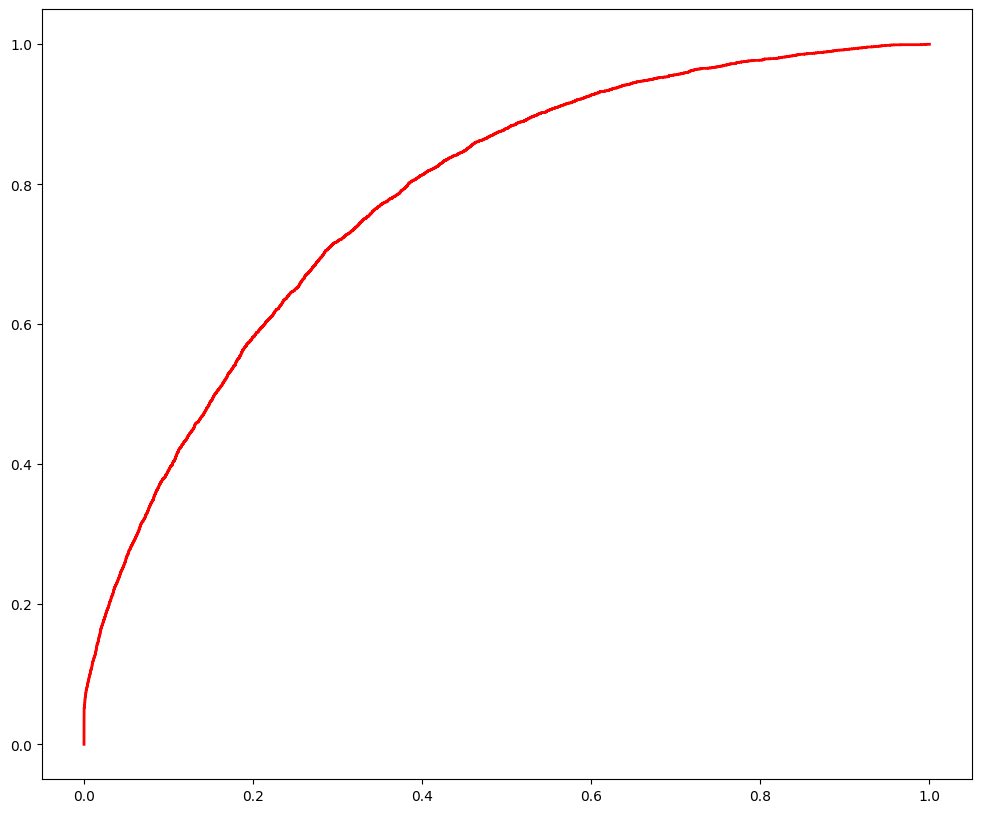

In [70]:
#XGB - Regulière

test_model_and_make_graphs('XGB', X_test_reguliere, y_test_reguliere)